# Project 1


#### `Libraries`


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

#### Solvers


1. Gauss Elimination


In [5]:
def GaussElimination(A, b):
    """Function that solves gauss elimination by elementary row operations.
    
    Keyword arguments:
    A - torch.Tensor(): matrix
    b - torch.Tensor(): vector
    Return: x -> solution vector
    """
    
    n = A.shape[0]
    
    # Forward Elimination
    for i in range(n-1):
        for j in range(i+1, n):
            factor = A[j, i] / A[i, i]
            A[j, i:] -= factor * A[i, i:]
            b[j] -= factor * b[i]

    # Back Substitution
    x = torch.zeros_like(b)
    for i in reversed(range(n)):
        s = torch.dot(A[i, i+1:], x[i+1:])
        x[i] = (b[i] - s) / A[i, i]

    return x


2. TDMA solver


In [6]:

def TDMA(d, l, u, b):
    """Function that solves TDMA using PyTorch.
    
    Keyword arguments:
    d - torch.Tensor(): diagonal vector
    l - torch.Tensor(): lower diagonal vector 
    u - torch.Tensor(): upper diagonal vector 
    b - torch.Tensor(): known vector 
    Return: x -> solution vector
    """
    
    n = len(d)
    
    # Forward elimination
    for i in range(1, n):
        factor = l[i-1] / d[i-1]
        d[i] = d[i] - factor * u[i-1]
        b[i] = b[i] - factor * b[i-1]
    
    # Back substitution
    x = torch.zeros_like(b)
    x[-1] = b[-1] / d[-1]
    for i in reversed(range(n-1)):
        x[i] = (b[i] - u[i] * x[i+1]) / d[i]

    return x

#### Plotters


In [7]:
def field_plotter(contour_vals):
    X = contour_vals[0].cpu().numpy()
    Y = contour_vals[1].cpu().numpy()
    Z = contour_vals[2].reshape(N,N).cpu().numpy()
    X, Y = np.meshgrid(X,Y)
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, Z, cmap='jet', levels=50)
    plt.colorbar(contour, label='Phi')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Contour Plot {contour_vals[3]} X {contour_vals[3]} grid')
    plt.show()

In [8]:
def CPU_Time(input_sizes, runtimes):
    plt.figure(figsize=(10, 6))
    plt.plot(input_sizes, runtimes, marker='o', linestyle='-', color='b')
    plt.xlabel('Input Size')
    plt.ylabel('CPU Runtime (seconds)')
    plt.title('CPU Runtime vs Input Size')
    plt.grid(True)
    plt.show()

##### Boundry Conditions and Source Term


In [9]:
phi_left = lambda y: 500 * torch.exp(-50 * (1 + y**2))
phi_right = lambda y: 100 * (1 - y) + 500 * torch.exp(-50 * y**2)
phi_bottom = lambda x: 100 * x + 500 * torch.exp(-50 * (1 - x)**2)
phi_top = lambda x: 500 * torch.exp(-50 * ((1 - x)**2 + 1))

source_term = lambda x, y: 50000 * torch.exp(-50 * ((1 - x)**2 + y**2)) * (100 * ((1 - x)**2 + y**2) - 2)


##### Generalized equation


In [10]:
def Matrix_Generation(N):
    delta = 1.0 / (N - 1)

    A = torch.zeros((N * N, N * N), device='cuda')
    b = torch.zeros(N * N, device='cuda')
    x = torch.linspace(0, 1, N, device='cuda')
    y = torch.linspace(0, 1, N, device='cuda')

    for i in range(N):
        for j in range(N):
            k = i * N + j

            b[k] += (delta**2) * source_term(x[i], y[j])

            A[k, k] = -4
            if j > 0:
                A[k, k - 1] = 1
                    
            if j < N - 1:
                A[k, k + 1] = 1
            if i > 0:
                A[k, k - N] = 1
            if i < N - 1:
                A[k, k + N] = 1

            if i == 0:
                b[k] -= phi_bottom(y[j])
            if i == N-1:
                b[k] -= phi_top(y[j])
            if j == 0:
                b[k] -= phi_left(x[i])
            if j == N-1:
                b[k] -= phi_right(x[i])

    return A, b, x, y


## Solution using Gauss Elimination


In [ ]:
grid_points = [21,41,81]
runtimes_GE = []
contour_vals_GE = []

for N in grid_points:
    print(f"Running for grid size: {N} x {N}")
    start = time.time()
    A,b,x,y = Matrix_Generation(N)
    phi = GaussElimination(A,b)
    end = time.time()
    contour_vals_GE.append((x,y,phi,N))
    runtimes_GE.append(end-start)


In [ ]:
runtimes_GE

In [ ]:
field_plotter(contour_vals_GE[2])

In [ ]:
CPU_Time([21,41,81], runtimes_GE)

## Solution using Gauss Siedel Itterative Method


In [11]:
def GaussSeidel(A, b, N, tol=1e-3):
    itter_ = 0
    phi = torch.zeros(N * N, device='cuda')
    residuals = []

    while True:
        itter_+=1
        phi_old = phi.clone()
        
        for i in range(N):
            for j in range(N):
                k = i * N + j
                
                sum1 = torch.dot(A[k, :k], phi[:k])
                sum2 = torch.dot(A[k, k+1:], phi[k+1:])
                phi[k] = (b[k] - sum1 - sum2) / A[k, k]

        residual = torch.norm(phi - phi_old)
        residuals.append(residual.item())
        print(residual)
        
        if residual / max(residuals) < tol:
            break

    return phi, residuals, itter_

In [12]:
grid_points = [41,81,161]
runtimes_GS = []
contour_vals_GS = []
itterations = []

for N in grid_points:
    print(f"Running for grid size: {N} x {N}")
    start = time.time()
    A,b,x,y = Matrix_Generation(N)
    phi, residuals,itter_ = GaussSeidel(A,b, N)
    end = time.time()
    contour_vals_GS.append((x,y,phi,N))
    runtimes_GS.append(end-start)
    itterations.append(itter_)

Running for grid size: 41 x 41


AssertionError: Torch not compiled with CUDA enabled

In [13]:
field_plotter(contour_vals_GS[2])

IndexError: list index out of range

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

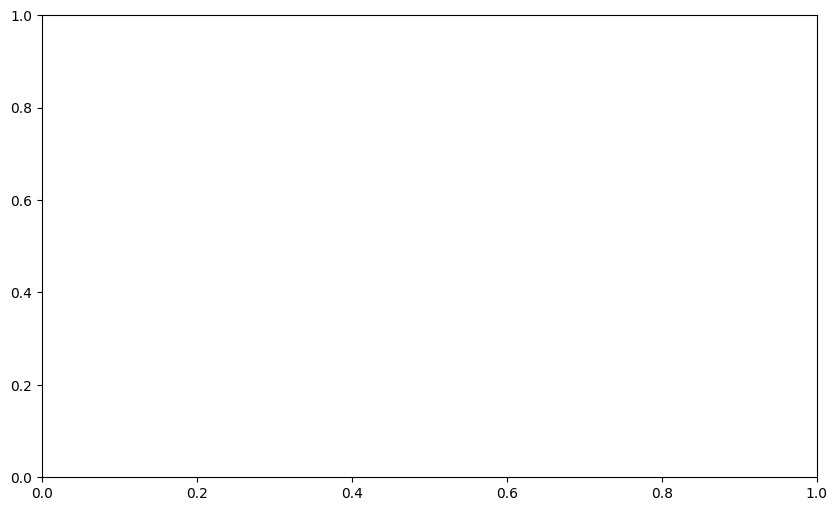

In [14]:
CPU_Time([41,81,161], runtimes_GS)

## Solution using Gauss Siedel [Line By Line] Itterative Method

In [ ]:
def GaussSeidel_RowSweep(A, b, N, tol=1e-6):
    
    phi = torch.zeros(N * N, device='cuda')
    residuals = []

    while True:
        phi_old = phi.clone()
        
        for i in range(N):
            d = torch.zeros(N, device='cuda')
            l = torch.zeros(N-1, device='cuda')
            u = torch.zeros(N-1, device='cuda')
            b_row = torch.zeros(N, device='cuda')
            
            for j in range(N):
                k = i * N + j
                d[j] = A[k, k]
                if j > 0:
                    l[j-1] = A[k, k-1]
                if j < N-1:
                    u[j] = A[k, k+1]
                b_row[j] = b[k] - torch.dot(A[k, :k], phi[:k]) - torch.dot(A[k, k+1:], phi[k+1:])
            
            phi[i*N:(i+1)*N] = TDMA(d, l, u, b_row)
        
        residual = torch.norm(phi - phi_old)
        residuals.append(residual.item())
        
        if residual / max(residuals) < tol:
            break

    return phi.reshape(N, N), residuals


In [ ]:
grid_points = [41,81,161]
runtimes_RS = []
contour_vals_RS = []
itterations_RS = []

for N in grid_points:
    print(f"Running for grid size: {N} x {N}")
    start = time.time()
    A,b,x,y = Matrix_Generation(N)
    phi, residuals,itter_ = GaussSeidel_RowSweep(A,b, N)
    end = time.time()
    contour_vals_GS.append((x,y,phi,N))
    runtimes_GS.append(end-start)
    itterations.append(itter_)

In [ ]:
field_plotter(contour_vals_RS[2])

In [ ]:
CPU_Time([41,81,161], runtimes_RS)